In [217]:
import pandas as pd
import numpy as np 
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, kurtosis, skew
from matplotlib import rc
import re
import json
import base64
from io import BytesIO

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [6]:
df = pd.read_csv("/Users/leeyein/Desktop/2024년 2학기/빅데이터종합설계/code/sample_cummulative_returns.csv",encoding="cp949")

In [12]:
df

,Date,Benchmark,Model
0,2020-06-01,0.00000,0.00000
1,2020-06-02,0.01160,-0.00945
2,2020-06-03,0.04350,-0.02017
3,2020-06-04,0.04277,-0.01883
4,2020-06-05,0.05755,-0.02777
...,...,...,...
705,2023-05-11,0.28832,0.06804
706,2023-05-12,0.28021,0.06208
707,2023-05-15,0.28302,0.06744
708,2023-05-16,0.28224,0.04551


In [282]:
class visualization:
    
    def __init__(self,dataframe):
        self._data = dataframe
    
    def cumlativeReturns(self,json_filename="cumulative_returns.json"):
        df = self._data 
        #df["Model"] = (1 + df["Model"]).cumprod() - 1
        #df["Benchmark"] = (1 + df["Benchmark"]).cumprod() - 1
        df = df.dropna()
        dates = pd.to_datetime(df['Date'])
        strategy_returns = [x * 100 for x in df['Model']]
        benchmark_returns = [x * 100 for x in df['Benchmark']]

        plt.figure(figsize=(10, 6))
        plt.plot(dates, strategy_returns, label='Strategy', color='blue', linewidth=2)
        plt.plot(dates, benchmark_returns, label='Benchmark', color='gold', linewidth=2)

        plt.title('Cumulative Returns vs SPY', fontsize=14)
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Cumulative Returns (%)', fontsize=12)

        plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)  # 기준선(0%)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        
        # 그래프를 이미지로 저장 (Base64 인코딩)
        buffer = BytesIO()
        plt.savefig(buffer, format='png')
        buffer.seek(0)
        graph_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
        buffer.close()
        plt.close()

        # JSON 데이터 생성
        json_data = {
            "dates": dates.dt.strftime("%Y-%m-%d").tolist(),  # 날짜 리스트
            "strategy_returns": strategy_returns,  # 전략 수익률 리스트
            "benchmark_returns": benchmark_returns,  # 벤치마크 수익률 리스트
            "graph_image": graph_base64  # Base64로 인코딩된 그래프 이미지
        }

        # JSON 파일 저장
        with open(json_filename, "w") as json_file:
            json.dump(json_data, json_file, indent=4)
        
        print(f"Cumulative returns data and graph saved to {json_filename}")
    
    def compareFrame(self):
        df = self._data
        df = df.dropna()
        strategy_returns = df['Model']
        benchmark_returns = df['Benchmark']
        
       
        #누적수익률
        def cumulative_return(returns):
            if returns.empty or returns.isnull().all():
                return np.nan
            return (1 + returns).prod() - 1
        
        #cagr
        def cagr(returns, periods_per_year=252):
            total_return = (1 + returns).prod()
            n_years = len(returns) / periods_per_year
            if n_years == 0:
                return np.nan
            return total_return**(1 / n_years) - 1
        
        # Sharpe Ratio 계산
        def sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
            excess_returns = returns - risk_free_rate / periods_per_year
            if returns.std() == 0:
                return np.nan
            return np.sqrt(periods_per_year) * excess_returns.mean() / excess_returns.std()
        
        # Sortino Ratio 계산
        def sortino_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
            excess_returns = returns - risk_free_rate / periods_per_year
            downside_std = returns[returns < 0].std()
            if downside_std == 0 or np.isnan(downside_std):
                return np.nan
            return np.sqrt(periods_per_year) * excess_returns.mean() / downside_std
        
        #최대 낙폭(Max Drawdown) 계산
        def max_drawdown(returns):
            cumulative = (1 + returns).cumprod()
            drawdown = cumulative / cumulative.cummax() - 1
            if returns.empty:
                return np.nan
            return drawdown.min()
        
        # 변동성(Volatility) 계산
        def annual_volatility(returns, periods_per_year=252):
            if returns.std() == 0:
                return 0
            return returns.std() * np.sqrt(periods_per_year)
               
        # Calmar Ratio 계산
        def calmar_ratio(returns, periods_per_year=252):
            max_dd = max_drawdown(returns)
            if max_dd == 0:
                return np.nan
            return cagr(returns, periods_per_year) / abs(max_drawdown(returns))
        
        # Skewness 계산
        def skewness(returns):
            if len(returns) < 3:
                return np.nan
            return skew(returns)
        
        # Kurtosis 계산
        def kurtosis_calc(returns):
            if len(returns) < 3:
                return np.nan
            return kurtosis(returns)
        
        # Expected Daily
        def calculate_expected_returns_d(returns):
            expected_daily = np.mean(returns) * 100
            return expected_daily
        
        # Expected Monthly
        def calculate_expected_returns_m(returns):
            expected_monthly = ((1 + np.mean(returns))**21 - 1) * 100  # 21 거래일 한 달 기준
            return expected_monthly
        
        # Expected Yearly Returns
        def calculate_expected_returns_y(returns):
            expected_yearly = ((1 + np.mean(returns))**252 - 1) * 100  # 252 거래일 연간 기준
            return expected_yearly
        
        # Kelly Criterion
        def calculate_kelly_criterion(returns):
            mean_return = np.mean(returns)
            variance = np.var(returns)
            if variance == 0:
                return np.nan
            kelly_criterion = (mean_return / variance) * 100
            return kelly_criterion
        
        # Risk of Ruin
        def calculate_risk_of_ruin():
            return 0.0  # Kelly 기준을 따르면 0%로 가정
    
        # Daily VaR (Value-at-Risk)
        def calculate_var(returns, confidence_level=0.95):
            z_score = norm.ppf(1 - confidence_level)  # 신뢰구간에 해당하는 Z-Score
            daily_volatility = np.std(returns)
            if daily_volatility == 0:
                return np.nan
            daily_var = z_score * daily_volatility * 100  # VaR (하루 손실율)  
            return daily_var
        
        # CVaR (Conditional Value-at-Risk)
        def calculate_cvar(returns, confidence_level=0.95):
            z_score = norm.ppf(1 - confidence_level)
            daily_volatility = np.std(returns)
            if daily_volatility == 0:
                return np.nan
            cvar = z_score * daily_volatility - (norm.pdf(z_score) / (1 - confidence_level)) * daily_volatility
            return cvar * 100
        
        metrics = {
        "Metric": [
            "Cumulative Return",
            "CAGR%",
            "Sharpe",
            "Sortino",
            "Max Drawdown",
            "Volatility (ann.)",
            "Calmar",
            "Skew",
            "Kurtosis",
            "Expected Daily %",
            "Expected Monthly %",
            "Expected Yearly %",
            "Kelly Criterion",
            "Risk of Ruin",
            "Daily Value-at-Risk (VaR)",
            "Expected Shortfall (CVaR)"],
            
        "Strategy": [
            cumulative_return(strategy_returns) * 100,
            cagr(strategy_returns) * 100,
            sharpe_ratio(strategy_returns),
            sortino_ratio(strategy_returns),
            max_drawdown(strategy_returns) * 100,
            annual_volatility(strategy_returns) * 100,
            calmar_ratio(strategy_returns),
            skewness(strategy_returns),
            kurtosis_calc(strategy_returns),
            calculate_expected_returns_d(strategy_returns),
            calculate_expected_returns_m(strategy_returns),
            calculate_expected_returns_y(strategy_returns),
            calculate_kelly_criterion(strategy_returns),
            calculate_risk_of_ruin(),
            calculate_var(strategy_returns),
            calculate_cvar(strategy_returns)],
            
        "Benchmark": [
            cumulative_return(benchmark_returns) * 100,
            cagr(benchmark_returns) * 100,
            sharpe_ratio(benchmark_returns),
            sortino_ratio(benchmark_returns),
            max_drawdown(benchmark_returns) * 100,
            annual_volatility(benchmark_returns) * 100,
            calmar_ratio(benchmark_returns),
            skewness(benchmark_returns),
            kurtosis_calc(benchmark_returns),
            calculate_expected_returns_d(benchmark_returns),
            calculate_expected_returns_m(benchmark_returns),
            calculate_expected_returns_y(benchmark_returns),
            calculate_kelly_criterion(benchmark_returns),
            calculate_risk_of_ruin(),
            calculate_var(benchmark_returns),
            calculate_cvar(benchmark_returns)]
            }
                
        def save_metrics_to_files(metrics, json_filename="metrics.json", pkl_filename="metrics.pkl"):
            # PKL 파일로 저장
            metrics.to_pickle(pkl_filename)
            print(f"Metrics saved as PKL: {pkl_filename}")
            
            # JSON 파일로 저장
            metrics.to_json(json_filename, orient="records", indent=4)
            print(f"Metrics saved as JSON: {json_filename}")

        df_metrics = pd.DataFrame(metrics)  
        save_metrics_to_files(df_metrics)
        print(df_metrics)
        return df_metrics

In [283]:
def showGraph(data):
    graph = visualization(data)
    graph.cumlativeReturns()

In [284]:
showGraph(df)

Cumulative returns data and graph saved to cumulative_returns.json


In [285]:
def showFrame(data):
    frame = visualization(data)
    f = frame.compareFrame()
    print(pd.DataFrame(f))

In [286]:
showFrame(df)

Metrics saved as PKL: metrics.pkl
Metrics saved as JSON: metrics.json
                       Metric      Strategy     Benchmark
0           Cumulative Return  6.288435e+47  9.722217e+86
1                       CAGR%  3.821474e+18  5.907888e+32
2                      Sharpe  2.077061e+01  3.169653e+01
3                     Sortino  7.472558e+01           NaN
4                Max Drawdown -9.761369e+01 -1.285000e+00
5           Volatility (ann.)  2.077143e+02  2.665379e+02
6                      Calmar  3.914896e+16  4.597578e+32
7                        Skew -4.218682e-01  8.757157e-02
8                    Kurtosis -8.926906e-01 -1.169987e+00
9            Expected Daily %  1.712045e+01  3.352510e+01
10         Expected Monthly %  2.662404e+03  4.323324e+04
11          Expected Yearly %  1.974448e+19  4.383836e+33
12            Kelly Criterion  1.001399e+03  1.190905e+03
13               Risk of Ruin  0.000000e+00  0.000000e+00
14  Daily Value-at-Risk (VaR) -2.150707e+01 -2.759775e+01
15

In [273]:
testlist = ['REET: 0.00%', 'USO: 3.92%', 'MTUM: 17.14%', 'SPLV: 14.97%', 'SRVR: 5.82%', 'XHB: 31.74%', 'SLV: 26.41%', 'JPST: 0.00%']

In [275]:
class indexVisualization:
    
    def __init__(self, datalist):
        self._data = datalist  # 초기 데이터 (주식 비중 정보)

    def Visualization(self):
        
        data = self._data  # 입력 데이터
        
        # 데이터를 처리하여 종목과 비중의 딕셔너리 생성
        def indexMetrics(data):
            """
            문자열 데이터를 딕셔너리로 변환 및 정렬.
            각 데이터 항목은 '종목: 비율%' 형식이며, 이를 {종목: 비율} 딕셔너리로 변환.
            """
            stocks_metrics = {}
            for i in range(len(data)):
                try:
                    stock, per = data[i].split(":")  # "삼성전자: 40%"
                    stock, per = stock.strip(), float(per.strip()[:-1])  # '삼성전자', '40'으로 변환
                    stocks_metrics[stock] = per
                except ValueError:
                    print(f"Invalid format in data: {data[i]}")
                    continue
            # 값(비율) 기준 내림차순 정렬
            stocks_metrics_sorted = dict(list(sorted(stocks_metrics.items(), key=lambda item: item[1], reverse=True)))
            return stocks_metrics_sorted  # 정렬된 딕셔너리 반환

        # 개별 종목 그래프 생성 및 이미지 저장
        def generateGraphImage(stock, percentage, maxvalue):
            """
            개별 종목 그래프를 생성하고, Base64로 인코딩된 이미지 데이터 반환.
            """
            # 그래프 생성
            plt.figure(figsize=(6, 1))
            plt.barh([stock], [percentage], color='skyblue', edgecolor='black')  # 가로 막대 그래프
            plt.xlim(0, maxvalue + 3)  # X축 범위를 전체 비율 최대값 +3으로 설정
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.show()  # 그래프 화면 출력
            
            # 그래프를 PNG 이미지로 저장 및 Base64로 변환
            buffer = BytesIO()  # 이미지 데이터를 임시 저장할 버퍼 생성
            plt.savefig(buffer, format='png')  # 그래프를 버퍼에 저장
            buffer.seek(0)  # 버퍼의 시작점으로 이동
            graph_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')  # Base64 인코딩
            buffer.close()  # 버퍼 닫기
            plt.close()  # 그래프 닫기
            
            return graph_base64  # Base64로 인코딩된 그래프 이미지 반환
        
        # 종목별 데이터를 처리하고, 그래프 이미지를 포함한 딕셔너리 생성
        def generateStockDict(data,json_filename="stock_barplot.json"):
            """
            정렬된 딕셔너리를 기반으로 각 종목의 비율과 그래프(Base64) 데이터를 포함한 딕셔너리 생성.
            """
            stock_dict = {}
            maxvalue = max(list(data.values()))  # 비율의 최대값 계산 (X축 범위 설정에 사용)
            for stock, percentage in data.items():
                graph_image = generateGraphImage(stock, percentage, maxvalue)  # 종목별 그래프 생성
                stock_dict[stock] = {
                    "percentage": percentage,  # 각 종목의 비율
                    "graph": graph_image       # Base64로 인코딩된 그래프 이미지
                }
                
            with open(json_filename, "w") as json_file:
                json.dump(stock_dict, json_file, indent=4)
    
            print(f"Stock data and graphs saved to {json_filename}")
            
            return stock_dict  # 최종 데이터 반환
        
        # 1. 입력 데이터를 딕셔너리로 변환 및 정렬
        metrics = indexMetrics(data)
        # 2. 종목별 데이터를 포함한 딕셔너리 생성
        final_dict = generateStockDict(metrics)
        return final_dict  # 최종 데이터 반환


In [276]:
def showIndexBarplot(data):
    index = indexVisualization(data)
    index_bar_dict = index.Visualization()
    #return index_bar_dict

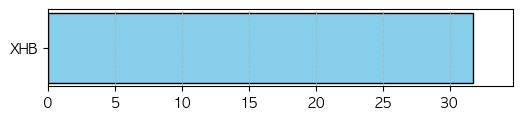

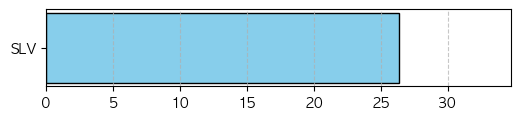

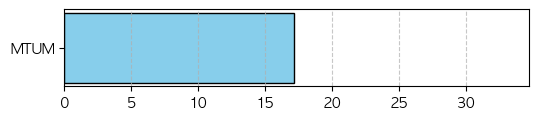

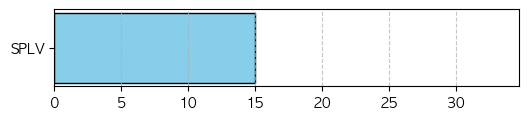

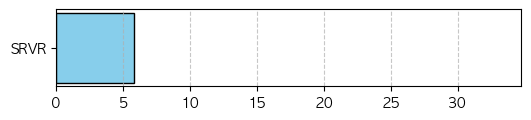

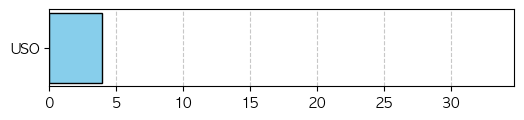

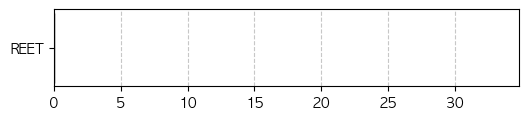

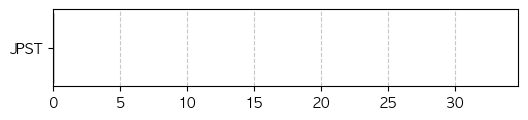

Stock data and graphs saved to stock_barplot.json


In [277]:
showIndexBarplot(testlist)